<a href="https://colab.research.google.com/github/Preethijenitha/Kolam-Design-REC-Kolam-Design-Rules-Extraction-Recreation-/blob/main/KolamDesignREC(Kolam_Design_Rules_Extraction_%26_Recreation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload a kolam image file (png/jpg). Use the chooser that opens.


Saving kolam.jpg to kolam (1).jpg
Analyzing 'kolam (1).jpg' ...


Has Cycles,True
Cycle Count,13296
Is Single Path,False
Symmetry,reflectional or unknown
Grid Type,hexagonal
Grid Size,1
Node Count,42491
Edge Count,51177


Using device: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Generating your Kolam based on the extracted design principles...
Prompt: A beautiful, intricate Kolam rangoli design with a hexagonal grid pattern, featuring reflectional symmetry, containing elegant loops and cycles, based on a 1x1 grid structure, using traditional red and white colors on a dark background, with clear, precise lines and professional illustration quality, intricate patterns, sacred geometry, spiritual symbolism


  0%|          | 0/30 [00:00<?, ?it/s]


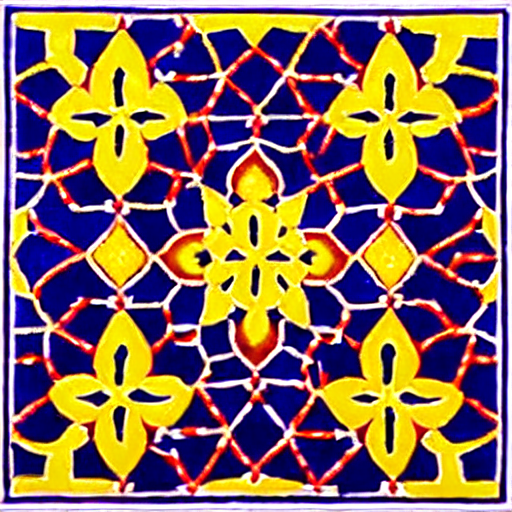

In [1]:
# 1) Install required packages (uncomment and run once in Colab)
# !pip install --quiet svgwrite networkx scikit-learn scipy matplotlib opencv-python-headless diffusers accelerate transformers

# 2) Imports
import numpy as np
import cv2
import networkx as nx
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy import spatial
from io import BytesIO
import base64
import tempfile
import os
from google.colab import files
from IPython.display import SVG, display, HTML, Image
import math
import torch
from diffusers import StableDiffusionPipeline

# ---------- KolamAnalyzer (extracts design principles) ----------
class KolamAnalyzer:
    def __init__(self):
        self.dots = []
        self.paths = []           # will hold compressed polylines (list of (x,y) tuples)
        self.graph = nx.Graph()
        self.symmetry = None
        self.grid_type = None
        self.grid_size = 0
        self.rules = {}

    def preprocess_image(self, image_path_or_bytes):
        """Preprocess the image to prepare for analysis."""
        if isinstance(image_path_or_bytes, (bytes, bytearray)):
            nparr = np.frombuffer(image_path_or_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        else:
            img = cv2.imread(image_path_or_bytes)
            if img is None:
                raise ValueError("Could not read image from path: " + str(image_path_or_bytes))

        max_dim = 1200
        h, w = img.shape[:2]
        if max(h, w) > max_dim:
            scale = max_dim / float(max(h, w))
            img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)

        kernel = np.ones((3, 3), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel, iterations=1)

        return cleaned, img.shape

    def detect_dots(self, binary_image):
        """Detect dots (pulli) in the kolam design using blob detection"""
        params = cv2.SimpleBlobDetector_Params()
        params.filterByArea = True
        params.minArea = 5
        params.maxArea = 5000
        params.filterByCircularity = False
        params.filterByConvexity = False
        params.filterByInertia = False

        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(binary_image)
        dots = [kp.pt for kp in keypoints]

        if len(dots) < 5:
            # fallback to contours
            contours_info = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # findContours can return 2 or 3 values depending on OpenCV; handle both
            contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]
            alt = []
            for c in contours:
                area = cv2.contourArea(c)
                if 5 < area < 2000:
                    M = cv2.moments(c)
                    if M.get("m00", 0) != 0:
                        cx = M["m10"]/M["m00"]
                        cy = M["m01"]/M["m00"]
                        alt.append((cx, cy))
            if len(alt) > len(dots):
                dots = alt

        if len(dots) > 1:
            try:
                clustering = DBSCAN(eps=50, min_samples=2).fit(dots)
                labels = clustering.labels_
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 0:
                    self.grid_size = int(round(math.sqrt(max(1, n_clusters))))
                else:
                    self.grid_size = 0
                self.determine_grid_type(dots, labels)
            except Exception:
                self.grid_type = "unknown"

        self.dots = dots
        return dots

    def determine_grid_type(self, dots, labels=None):
        if len(dots) < 4:
            self.grid_type = "unknown"
            return
        coords = np.array(dots)
        dists = spatial.distance.pdist(coords)
        if len(dists) == 0:
            self.grid_type = "unknown"
            return
        # round to nearest 10 pixels
        unique_dists = np.unique(np.round(dists, -1))
        if len(unique_dists) <= 3:
            self.grid_type = "square"
            return
        angles = []
        for i in range(len(dots)):
            for j in range(i+1, len(dots)):
                dx = dots[j][0]-dots[i][0]
                dy = dots[j][1]-dots[i][1]
                dist = math.hypot(dx, dy)
                if dist < 150:
                    angles.append(math.atan2(dy, dx))
        if not angles:
            self.grid_type = "circular"
            return
        angle_hist = np.histogram(angles, bins=12)
        if len([x for x in angle_hist[0] if x > 0]) >= 6:
            self.grid_type = "hexagonal"
        else:
            self.grid_type = "circular"

    def skeletonize(self, image):
        img = image.copy()
        if img.max() == 1:
            img = (img * 255).astype('uint8')
        skel = np.zeros(img.shape, np.uint8)
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        # Use morphological thinning-like approach (works but can be slow on big images)
        while True:
            eroded = cv2.erode(img, element)
            temp = cv2.dilate(eroded, element)
            temp = cv2.subtract(img, temp)
            skel = cv2.bitwise_or(skel, temp)
            img = eroded.copy()
            if cv2.countNonZero(img) == 0:
                break
        # convert to binary 0/1
        skel_bin = (skel != 0).astype(np.uint8)
        return skel_bin

    def find_keypoints(self, skeleton):
        """Return endpoints and junctions by counting neighbors (exclude center pixel)"""
        endpoints = []
        junctions = []
        h, w = skeleton.shape
        for y in range(1, h-1):
            for x in range(1, w-1):
                if skeleton[y, x] != 0:
                    nb = skeleton[y-1:y+2, x-1:x+2]
                    # exclude center pixel from neighbor count
                    count = np.sum(nb != 0) - 1
                    if count == 1:
                        endpoints.append((x, y))
                    elif count >= 3:
                        junctions.append((x, y))
        return endpoints, junctions

    def build_graph_from_skeleton(self, skeleton):
        """Add every skeleton pixel as a node and connect 8-neighbors (so we can compress later)."""
        self.graph = nx.Graph()
        ys, xs = np.nonzero(skeleton)
        for x, y in zip(xs, ys):
            self.graph.add_node((x, y))
        h, w = skeleton.shape
        # add edges for 8-connectivity
        for x, y in zip(xs, ys):
            for dx, dy in [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]:
                nxp, nyp = x + dx, y + dy
                if (nxp, nyp) in self.graph:
                    self.graph.add_edge((x, y), (nxp, nyp))

    def compress_paths_from_graph(self):
        """
        Compress pixel-level skeleton graph into polylines:
        - nodes with degree != 2 are keypoints (endpoints & junctions)
        - traverse edges between keypoints through degree==2 nodes to form polylines
        """
        self.paths = []
        G = self.graph
        if len(G.nodes) == 0:
            return

        # identify keypoints (degree != 2)
        keypoints = {n for n, d in G.degree() if d != 2}
        # if no keypoints found (closed single loop), choose an arbitrary node as keypoint
        if not keypoints:
            arbitrary = next(iter(G.nodes))
            keypoints = {arbitrary}

        visited_edges = set()  # store frozenset of node pairs

        def edge_id(a, b):
            return tuple(sorted([a, b]))

        for kp in keypoints:
            for nbr in G.neighbors(kp):
                eid = edge_id(kp, nbr)
                if eid in visited_edges:
                    continue
                # start a path
                path = [kp, nbr]
                visited_edges.add(eid)
                cur = nbr
                prev = kp
                # walk until reach another keypoint or cannot continue
                while True:
                    if cur in keypoints:
                        break
                    # cur degree should be 2 in the chain
                    neighbors = [n for n in G.neighbors(cur) if n != prev]
                    if not neighbors:
                        break
                    nxt = neighbors[0]
                    visited_edges.add(edge_id(cur, nxt))
                    path.append(nxt)
                    prev, cur = cur, nxt
                self.paths.append(path)

        # There may be edges between keypoints not covered (e.g., in loops). Add any remaining edges.
        for a, b in G.edges():
            eid = edge_id(a, b)
            if eid not in visited_edges:
                # simple path of two nodes
                visited_edges.add(eid)
                self.paths.append([a, b])

    def analyze_paths(self):
        cycles = []
        try:
            cycles = list(nx.cycle_basis(self.graph)) if len(self.graph.nodes) > 0 else []
        except Exception:
            cycles = []
        is_single_path = nx.is_connected(self.graph) if len(self.graph.nodes) > 0 else False
        self.detect_symmetry()
        self.rules = {
            "has_cycles": len(cycles) > 0,
            "cycle_count": len(cycles),
            "is_single_path": is_single_path,
            "symmetry": self.symmetry,
            "grid_type": self.grid_type,
            "grid_size": self.grid_size,
            "node_count": len(self.graph.nodes),
            "edge_count": len(self.graph.edges)
        }

    def detect_symmetry(self):
        if not self.dots or len(self.graph.nodes) == 0:
            self.symmetry = "unknown"
            return
        # use *dot* locations if available (less noisy than all pixel-nodes)
        try:
            points = np.array(self.dots)
            centroid = np.mean(points, axis=0)
            angles = [math.atan2(p[1]-centroid[1], p[0]-centroid[0]) for p in points]
        except Exception:
            points = np.array(list(self.graph.nodes))
            centroid = np.mean(points, axis=0)
            angles = [math.atan2(p[1]-centroid[1], p[0]-centroid[0]) for p in points]
        angle_bins = np.linspace(0, 2*math.pi, 13)
        hist, _ = np.histogram(angles, bins=angle_bins)
        for n in [2,3,4,6,8]:
            peak_count = sum(hist > len(angles) / (2 * n)) if len(angles) > 0 else 0
            if peak_count >= n:
                self.symmetry = f"{n}-fold rotational"
                return
        self.symmetry = "reflectional or unknown"

    def extract_paths(self, binary_image):
        skeleton = self.skeletonize(binary_image)
        endpoints, junctions = self.find_keypoints(skeleton)
        # build a full graph of skeleton pixels
        self.build_graph_from_skeleton(skeleton)
        # compress the pixel graph into polyline segments
        self.compress_paths_from_graph()
        # analyze for cycles, connectivity, symmetry
        self.analyze_paths()
        return self.paths

    def analyze_kolam(self, image_path_or_bytes):
        binary_img, original_shape = self.preprocess_image(image_path_or_bytes)
        self.detect_dots(binary_img)
        self.extract_paths(binary_img)
        return self.rules

# ---------- Stable Diffusion Integration ----------
def create_kolam_prompt(rules):
    """Create a detailed prompt for Stable Diffusion based on extracted kolam design principles"""
    prompt = "A beautiful, intricate Kolam rangoli design"
    grid_type = rules.get('grid_type', 'unknown')
    if grid_type == 'square':
        prompt += " with a square grid pattern"
    elif grid_type == 'hexagonal':
        prompt += " with a hexagonal grid pattern"
    elif grid_type == 'circular':
        prompt += " with concentric circular patterns"
    symmetry = rules.get('symmetry', 'unknown')
    if 'rotational' in symmetry:
        prompt += f", featuring {symmetry} symmetry"
    elif 'reflectional' in symmetry:
        prompt += ", featuring reflectional symmetry"
    if rules.get('has_cycles', False):
        prompt += ", containing elegant loops and cycles"
    else:
        prompt += ", designed with continuous flowing lines"
    grid_size = rules.get('grid_size', 0)
    if grid_size > 0:
        prompt += f", based on a {grid_size}x{grid_size} grid structure"
    prompt += ", using traditional red and white colors on a dark background"
    prompt += ", with clear, precise lines and professional illustration quality"
    prompt += ", intricate patterns, sacred geometry, spiritual symbolism"
    return prompt

def setup_stable_diffusion():
    """Set up the Stable Diffusion pipeline (guarded for GPU / environment)"""
    # check GPU availability
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA GPU is not available in this environment. Enable GPU runtime in Colab (Runtime > Change runtime type > GPU).")
    try:
        device_name = torch.cuda.get_device_name(0)
    except Exception:
        device_name = "cuda"
    print(f"Using device: {device_name}")
    model_id = "runwayml/stable-diffusion-v1-5"
    # Load the model (may require HF token depending on model access)
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    # enable attention slicing to save memory if supported
    try:
        pipe.enable_attention_slicing()
    except Exception:
        pass
    return pipe

def generate_kolam_image(pipe, prompt):
    """Generate a kolam image using Stable Diffusion with some reasonable defaults"""
    negative_prompt = "asymmetric, blurry, messy, text, words, human, photo, modern, digital, 3D"
    print("Generating your Kolam based on the extracted design principles...")
    print(f"Prompt: {prompt}")
    # use typical parameters
    res = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=30, guidance_scale=7.5)
    # the pipeline returns an object with .images (list)
    image = res.images[0]
    return image

# ---------- Main Function ----------
def analyze_and_generate_kolam():
    """Main function to analyze an uploaded kolam and generate a new one"""
    print("Upload a kolam image file (png/jpg). Use the chooser that opens.")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Get the uploaded file
    fname = next(iter(uploaded))
    content = uploaded[fname]
    print(f"Analyzing '{fname}' ...")

    # Analyze the kolam
    analyzer = KolamAnalyzer()
    try:
        rules = analyzer.analyze_kolam(content)
    except Exception as e:
        print("Error during analysis:", e)
        return

    # Display the extracted principles in a beautiful format
    display(HTML("<h2 style='color: #4a2c82; text-align: center;'>Extracted Kolam Design Principles</h2>"))

    principles_html = """
    <div style="background-color: #f9f7fe; padding: 20px; border-radius: 10px; margin: 20px 0;">
        <table style="width: 100%; border-collapse: collapse;">
    """

    for k, v in rules.items():
        principles_html += f"""
        <tr style="border-bottom: 1px solid #e0d6ff;">
            <td style="padding: 10px; font-weight: bold; color: #4a2c82;">{k.replace('_', ' ').title()}</td>
            <td style="padding: 10px; color: #6b4c9f;">{v}</td>
        </tr>
        """

    principles_html += """
        </table>
    </div>
    """

    display(HTML(principles_html))

    # Create prompt and generate new kolam
    prompt = create_kolam_prompt(rules)

    # Set up Stable Diffusion
    try:
        pipe = setup_stable_diffusion()
    except Exception as e:
        print(f"Error setting up Stable Diffusion: {e}")
        print("Skipping image generation. You can still view the extracted design principles.")
        return

    # Generate the new kolam
    try:
        generated_image = generate_kolam_image(pipe, prompt)

        # Display the generated kolam (robust embed & download)
        display(HTML("<h2 style='color: #4a2c82; text-align: center;'>Generated Kolam Design</h2>"))
        display(HTML("<p style='text-align: center;'>Based on the extracted design principles</p>"))

        # Convert PIL image to bytes and then to base64 so we can reliably embed & download it
        out_buf = BytesIO()
        generated_image.save(out_buf, format='PNG')
        out_buf.seek(0)
        b64 = base64.b64encode(out_buf.getvalue()).decode('ascii')

        # Display the image with a fixed id so JS download targets this image only
        img_html = f"""
        <div style="text-align:center; margin-top:10px;">
            <img id="gen_kolam" src="data:image/png;base64,{b64}" style="max-width: 90%; height: auto; border: 1px solid #e6e0f7; border-radius: 8px;"/>
        </div>
        """
        display(HTML(img_html))

        # Download button that explicitly uses the above image's src
        download_html = """
        <div style="text-align: center; margin: 20px;">
            <a id="download_link" download="generated_kolam.png">
                <button style="background-color: #4a2c82; color: white; padding: 10px 20px; border: none; border-radius: 5px; cursor: pointer;">
                    Download Generated Kolam
                </button>
            </a>
        </div>
        <script>
        const img = document.getElementById('gen_kolam');
        const link = document.getElementById('download_link');
        if (img && link) {
            link.href = img.src;
        }
        </script>
        """
        display(HTML(download_html))

    except Exception as e:
        print(f"Error generating kolam: {e}")

# Run the main function
analyze_and_generate_kolam()
